## Project: Predicting On-Time Delivery for E-Commerce Shipments Using Machine Learning
 
This project focuses on predicting whether product deliveries for an international electronics retailer will arrive **on time or be delayed**, using historical order data. The solution leverages machine learning algorithms such as **Logistic Regression, Random Forest, XGBoost, and LightGBM** for classification.

The entire workflow is tracked using **MLflow** for experiment management, and the final model is deployed through a **Streamlit dashboard** to provide an interactive interface for business users and logistics planners.


# Setup the Environment

In [1]:
# Install required packages
%pip install pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm mlflow --quiet

# Enable inline plotting in notebook
%matplotlib inline

# Import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import scikit-learn modules
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)

# Import gradient boosting libraries
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Import MLflow for experiment tracking and model logging
import os
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm
import joblib
import pickle


Note: you may need to restart the kernel to use updated packages.


# Data Loading and Overview


In [2]:
df = pd.read_csv('/Users/root/E-Commerce_Prediction_Project/data/e_commerce.csv')
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [3]:
# Rename the target column for clarity
df.rename(columns={'Reached.on.Time_Y.N': 'Reached_on_time'}, inplace=True)

In [4]:
# Information about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached_on_time      10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB
None


In [5]:
# Descriptive Statistics
df.describe(include='all')

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached_on_time
count,10999.00000,10999,10999,10999.000000,10999.000000,10999.000000,10999.000000,10999,10999,10999.000000,10999.000000,10999.000000
unique,NaN,5,3,NaN,NaN,NaN,NaN,3,2,NaN,NaN,NaN
top,NaN,F,Ship,NaN,NaN,NaN,NaN,low,F,NaN,NaN,NaN
freq,NaN,3666,7462,NaN,NaN,NaN,NaN,5297,5545,NaN,NaN,NaN
mean,5500.00000,NaN,NaN,4.054459,2.990545,210.196836,3.567597,NaN,NaN,13.373216,3634.016729,0.596691
std,3175.28214,NaN,NaN,1.141490,1.413603,48.063272,1.522860,NaN,NaN,16.205527,1635.377251,0.490584
min,1.00000,NaN,NaN,2.000000,1.000000,96.000000,2.000000,NaN,NaN,1.000000,1001.000000,0.000000
25%,2750.50000,NaN,NaN,3.000000,2.000000,169.000000,3.000000,NaN,NaN,4.000000,1839.500000,0.000000
50%,5500.00000,NaN,NaN,4.000000,3.000000,214.000000,3.000000,NaN,NaN,7.000000,4149.000000,1.000000
75%,8249.50000,NaN,NaN,5.000000,4.000000,251.000000,4.000000,NaN,NaN,10.000000,5050.000000,1.000000


In [6]:
# checking for null values
df.isnull().sum()

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached_on_time        0
dtype: int64

In [7]:
# Checking for duplicates
df[df.duplicated()]

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached_on_time


In [8]:
# Unique values for all columns
for col in df.columns:
    print(f"{col}: {df[col].unique()[:10]}")  # show first 10 unique values only

ID: [ 1  2  3  4  5  6  7  8  9 10]
Warehouse_block: ['D' 'F' 'A' 'B' 'C']
Mode_of_Shipment: ['Flight' 'Ship' 'Road']
Customer_care_calls: [4 2 3 5 6 7]
Customer_rating: [2 5 3 1 4]
Cost_of_the_Product: [177 216 183 176 184 162 250 233 150 164]
Prior_purchases: [ 3  2  4  6  5  7 10  8]
Product_importance: ['low' 'medium' 'high']
Gender: ['F' 'M']
Discount_offered: [44 59 48 10 46 12  3 11 29 32]
Weight_in_gms: [1233 3088 3374 1177 2484 1417 2371 2804 1861 1187]
Reached_on_time: [1 0]


# Exploratory Data Analysis (EDA)


**Categorical EDA**

Warehouse_block unique values: ['D' 'F' 'A' 'B' 'C']


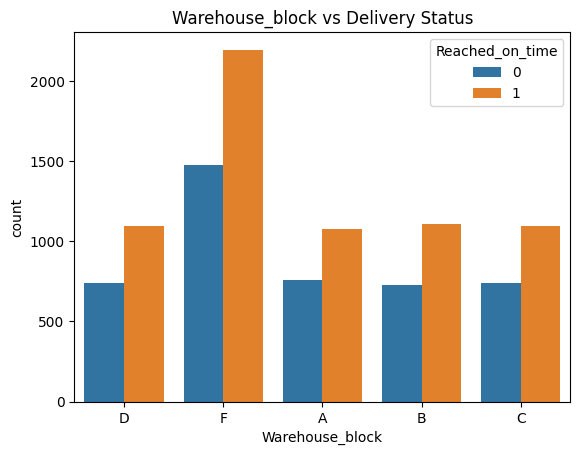

Mode_of_Shipment unique values: ['Flight' 'Ship' 'Road']


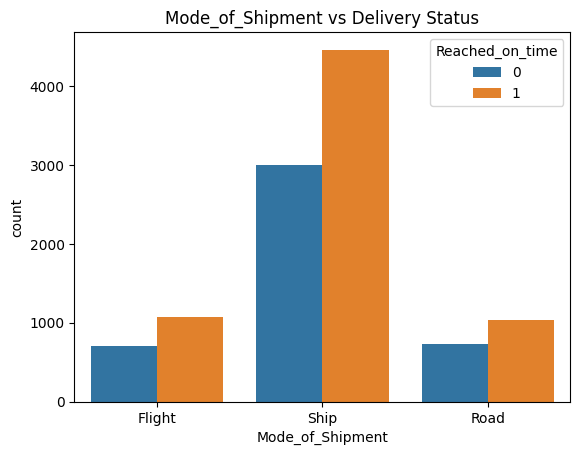

Product_importance unique values: ['low' 'medium' 'high']


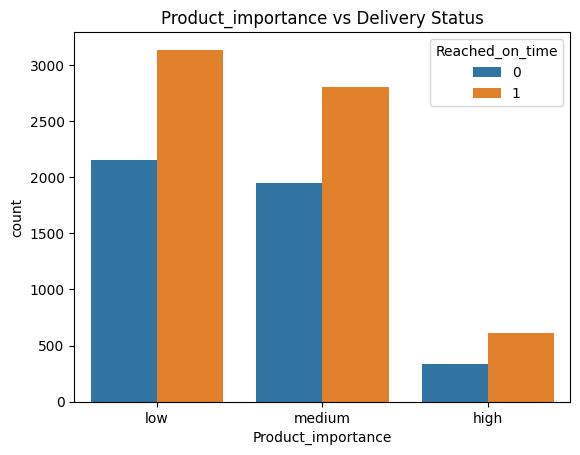

Gender unique values: ['F' 'M']


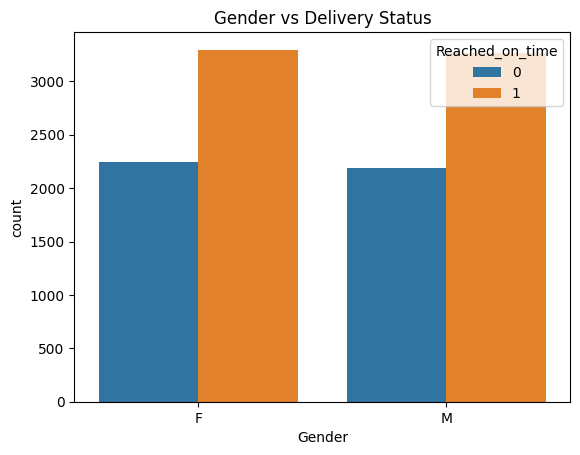

In [9]:
# Specifying columns as categorical 
cat_cols = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']
for col in cat_cols:
    print(f"{col} unique values: {df[col].unique()}")
    sns.countplot(x=col, hue='Reached_on_time', data=df)
    plt.title(f'{col} vs Delivery Status')
    plt.show()
    ## Note: 1 Indicates that the product has NOT reached on time and 0 indicates it has reached on time

**Numerical EDA**

Reached_on_time
1    0.596691
0    0.403309
Name: proportion, dtype: float64


<Axes: xlabel='Reached_on_time', ylabel='count'>

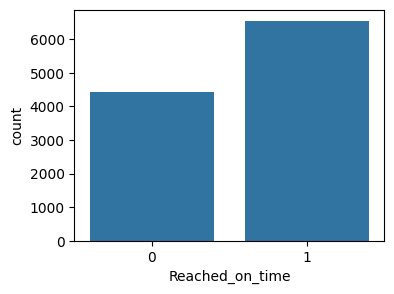

In [10]:
# Check class distribution for balanced dataset
print(df['Reached_on_time'].value_counts(normalize=True))
plt.figure(figsize=(4, 3))
sns.countplot(x='Reached_on_time', data=df)

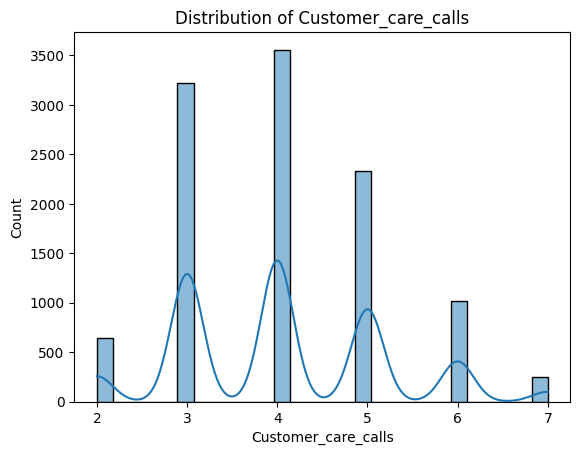

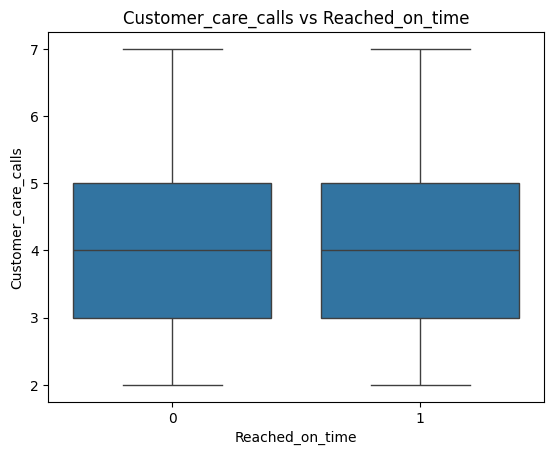

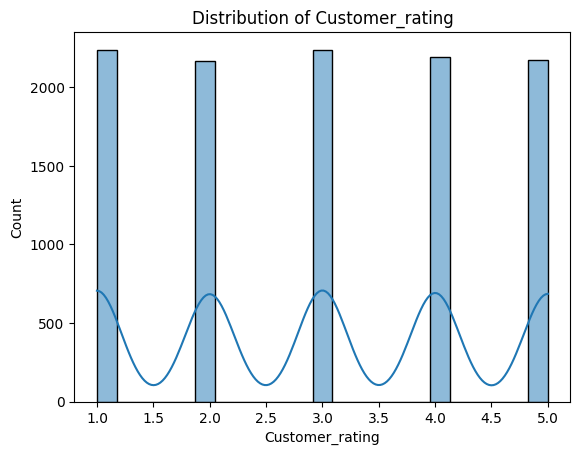

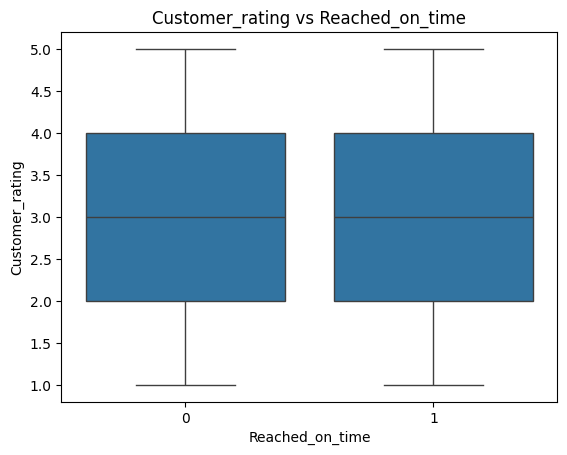

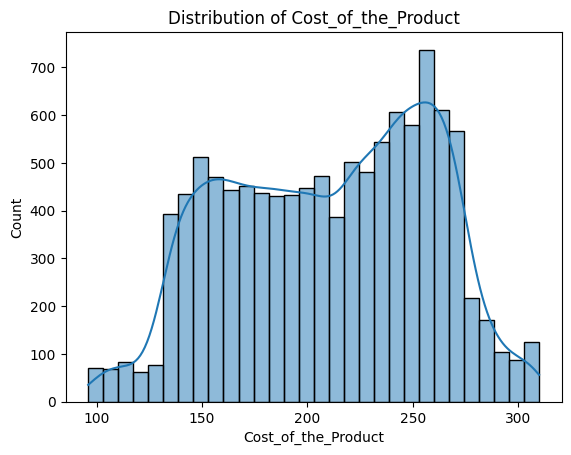

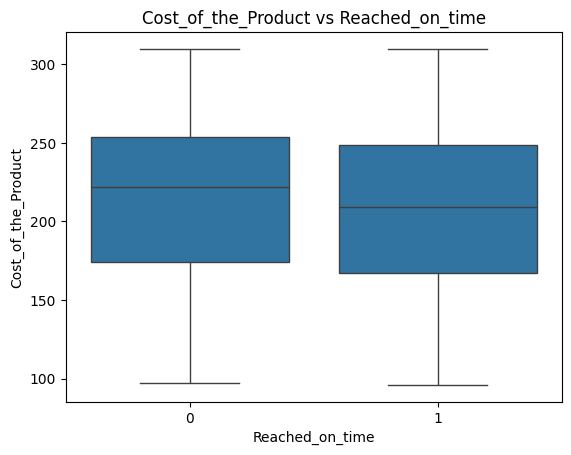

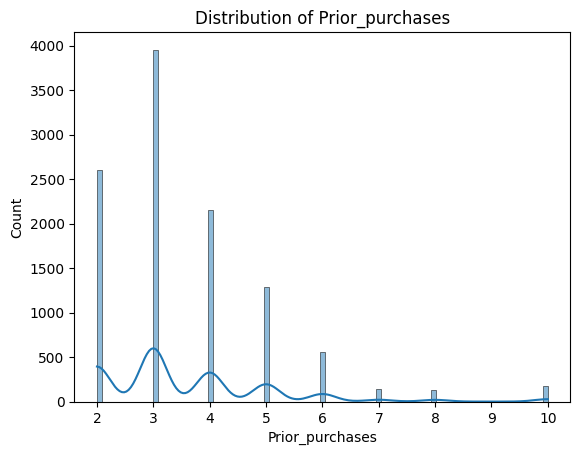

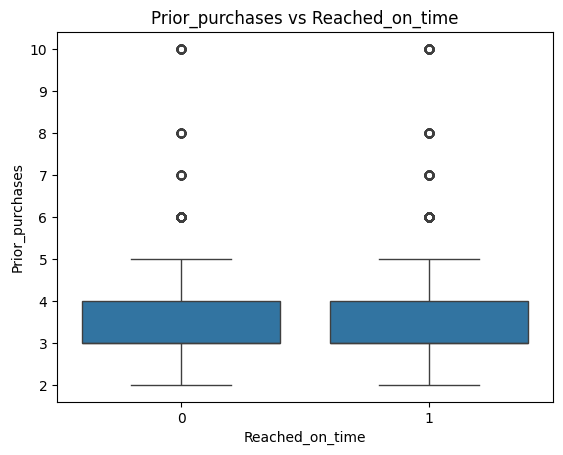

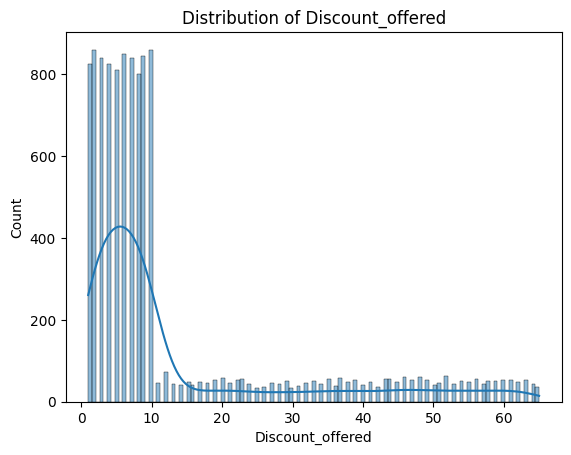

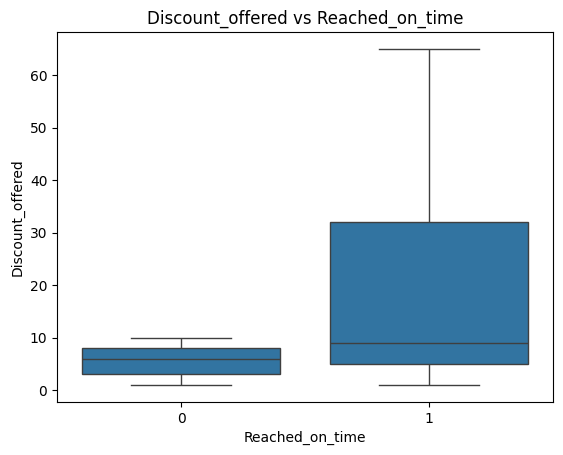

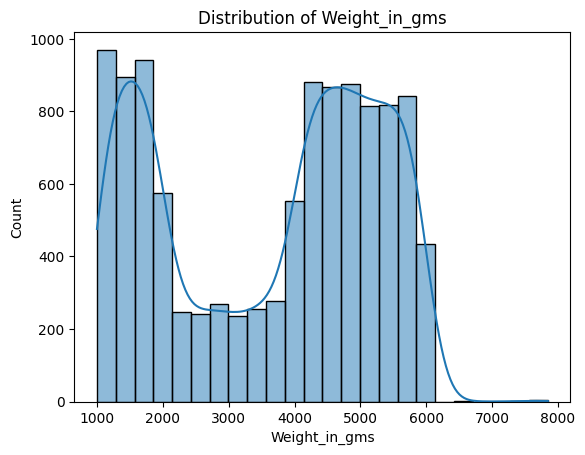

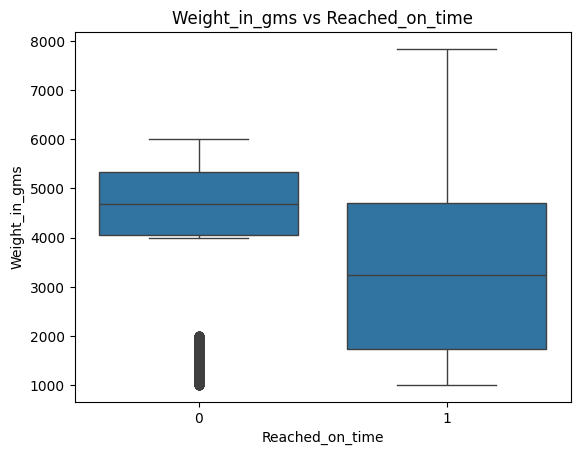

In [11]:
# List of numerical columns to analyze
num_cols = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product',
            'Prior_purchases', 'Discount_offered', 'Weight_in_gms']

# Loop through each numerical column to plot distribution and boxplots
for col in num_cols:
    # Plotting the distribution (histogram + KDE) for the current column
    sns.histplot(data=df, x=col, kde=True)  # Histogram with Kernel Density Estimate
    plt.title(f'Distribution of {col}')  # Title for the plot
    plt.show()  # Display the histogram

    # Plotting the boxplot of the current column grouped by 'Reached_on_time'
    sns.boxplot(x='Reached_on_time', y=col, data=df)  # Boxplot by delivery status
    plt.title(f'{col} vs Reached_on_time')  # Title for the boxplot
    plt.show()  # Display the boxplot

In [12]:
# Descriptive statistics of the column 'Cost_of_the_Product' grouped by each warehouse block
df.groupby('Warehouse_block')['Cost_of_the_Product'].describe()

,count,mean,std,min,25%,50%,75%,max
Warehouse_block,,,,,,,,
A,1833.0,208.767594,48.623021,96.0,167.0,212.0,250.0,310.0
B,1833.0,212.159302,46.980005,96.0,174.0,219.0,251.0,310.0
C,1833.0,211.191489,47.421596,101.0,172.0,214.0,252.0,310.0
D,1834.0,210.907852,48.188264,96.0,170.0,216.0,252.0,310.0
F,3666.0,209.077196,48.545561,96.0,167.0,213.0,250.0,310.0


In [13]:
# Define numeric columns
num_cols = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product',
            'Prior_purchases', 'Discount_offered', 'Weight_in_gms']

# Function to detect outliers using IQR
def detect_outliers_iqr(df, columns):
    outlier_summary = {}

    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_count = outliers.shape[0]
        outlier_summary[col] = outlier_count

        print(f"{col}: {outlier_count} outliers detected.")

    return outlier_summary

# Run outlier detection
outlier_counts = detect_outliers_iqr(df, num_cols)

Customer_care_calls: 0 outliers detected.
Customer_rating: 0 outliers detected.
Cost_of_the_Product: 0 outliers detected.
Prior_purchases: 1003 outliers detected.
Discount_offered: 2209 outliers detected.
Weight_in_gms: 0 outliers detected.


In [14]:
# Create a correlation matrix for numeric features + target variable
# This helps understand relationships between features and with the target 'Reached_on_time'
corr_matrix = df[num_cols + ['Reached_on_time']].corr()
corr_matrix

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached_on_time
Customer_care_calls,1.000000,0.012209,0.323182,0.180771,-0.130750,-0.276615,-0.067126
Customer_rating,0.012209,1.000000,0.009270,0.013179,-0.003124,-0.001897,0.013119
Cost_of_the_Product,0.323182,0.009270,1.000000,0.123676,-0.138312,-0.132604,-0.073587
Prior_purchases,0.180771,0.013179,0.123676,1.000000,-0.082769,-0.168213,-0.055515
Discount_offered,-0.130750,-0.003124,-0.138312,-0.082769,1.000000,-0.376067,0.397108
Weight_in_gms,-0.276615,-0.001897,-0.132604,-0.168213,-0.376067,1.000000,-0.268793
Reached_on_time,-0.067126,0.013119,-0.073587,-0.055515,0.397108,-0.268793,1.000000


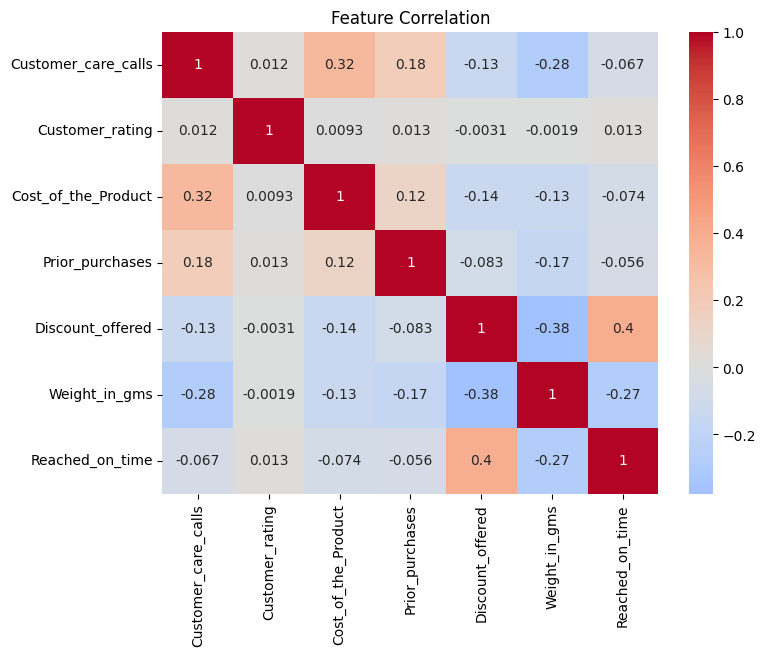

In [15]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df[num_cols + ['Reached_on_time']].corr(), annot=True, center=0, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

💡 **Correlation Analysis Summary:**
"Discount_offered" and "Weight_in_gms" show the strongest correlation with delivery delays. This suggests that promotions and product logistics are key factors. Customer interactions and ratings appear to have minimal predictive power.

# Feature Engineering


In [16]:
# Create new interaction features
num_cols = ['Customer_care_calls','Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']
df['Cost_per_gm'] = df['Cost_of_the_Product'] / df['Weight_in_gms']

# Add newly engineered numerical features to the list of numeric columns
num_cols = num_cols + ['Cost_per_gm']

In [17]:
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached_on_time,Cost_per_gm
0,1,D,Flight,4,2,177,3,low,F,44,1233,1,0.143552
1,2,F,Flight,4,5,216,2,low,M,59,3088,1,0.069948
2,3,A,Flight,2,2,183,4,low,M,48,3374,1,0.054238
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1,0.149533
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1,0.074074


# Train-Test Split



In [18]:
# Define feature matrix (X) by dropping the target and some selected features
# - 'Reached_on_time' is the target variable
# - 'ID' is likely an identifier and not useful for modeling
# - Other dropped columns like 'Customer_rating', 'Prior_purchases', etc., are excluded for modeling purposes
X = df.drop(columns=[
    'Customer_care_calls', 
    'Reached_on_time',    # Target variable
    'ID',                 # Identifier, not a predictive feature
    'Prior_purchases',    
    'Gender',  
    'Warehouse_block' 
])

# Define the target variable (y)
y = df['Reached_on_time']

# Split the dataset into training and testing sets
# - test_size=0.2: 20% of the data is reserved for testing
# - stratify=y: ensures class balance is preserved in both splits
# - random_state=42: ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Data Preprocessing

In [19]:
from scipy.stats import skew
# Calculate and display skewness
skewed_features = {}

print("Skewness Report:")
for col in num_cols:
    col_skew = skew(df[col].dropna())
    skewed_features[col] = col_skew
    print(f"{col}: Skewness = {col_skew:.3f}")
    if abs(col_skew) > 0.5:
        print(" → Moderately to highly skewed.\n")
    else:
        print(" → Approximately symmetric.\n")

Skewness Report:
Customer_care_calls: Skewness = 0.392
 → Approximately symmetric.

Customer_rating: Skewness = 0.004
 → Approximately symmetric.

Cost_of_the_Product: Skewness = -0.157
 → Approximately symmetric.

Prior_purchases: Skewness = 1.682
 → Moderately to highly skewed.

Discount_offered: Skewness = 1.799
 → Moderately to highly skewed.

Weight_in_gms: Skewness = -0.250
 → Approximately symmetric.

Cost_per_gm: Skewness = 1.420
 → Moderately to highly skewed.



In [20]:
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

In [21]:
# Paths to save scaler and columns for Streamlit use
models_path = "/Users/root/E-Commerce_Prediction_Project/models"
os.makedirs(models_path, exist_ok=True)

# 1. Scale numeric columns
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Save the scaler for Streamlit app
with open(os.path.join(models_path, 'scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)

# 2. One-hot encode categorical columns
X_train_encoded = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

# 3. Ensure test columns match train columns (fill missing with 0)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# 4. Convert all boolean columns to int (if any)
bool_cols = X_train_encoded.select_dtypes(include='bool').columns
X_train_encoded[bool_cols] = X_train_encoded[bool_cols].astype(int)
X_test_encoded[bool_cols] = X_test_encoded[bool_cols].astype(int)

# 5. Save final columns list for Streamlit app to enforce same order & columns
train_columns = X_train_encoded.columns.tolist()
with open(os.path.join(models_path, 'train_columns.pkl'), 'wb') as f:
    pickle.dump(train_columns, f)

# 6. Check dtypes (optional)
print(X_train_encoded.dtypes)

Customer_rating              float64
Cost_of_the_Product          float64
Discount_offered             float64
Weight_in_gms                float64
Cost_per_gm                  float64
Mode_of_Shipment_Road          int64
Mode_of_Shipment_Ship          int64
Product_importance_low         int64
Product_importance_medium      int64
dtype: object


In [22]:
X_train_encoded.head(), y_train.head(), X_test_encoded.head(), y_test.head()

(       Customer_rating  Cost_of_the_Product  Discount_offered  Weight_in_gms  \
 7920         -1.415468             1.056631         -0.270466       0.322365   
 1529          0.001852            -1.003783          0.782420      -1.206929   
 10521        -0.706808             0.224140         -0.270466       0.510849   
 9558          1.419173            -1.107845         -0.704008       0.617330   
 968           1.419173             1.285566          0.658551       0.004144   
 
        Cost_per_gm  Mode_of_Shipment_Road  Mode_of_Shipment_Ship  \
 7920     -0.294703                      1                      0   
 1529      0.328265                      0                      1   
 10521    -0.531997                      0                      1   
 9558     -0.811501                      0                      1   
 968      -0.080446                      0                      0   
 
        Product_importance_low  Product_importance_medium  
 7920                        0      

In [23]:
print("X_train shape:", X_train_encoded.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test_encoded.shape)
print("y_test shape:", y_test.shape)

X_train shape: (8799, 9)
y_train shape: (8799,)
X_test shape: (2200, 9)
y_test shape: (2200,)


# Model Training (LogReg, RF, XGBoost)


In [24]:
# Set paths
models_path = "/Users/root/E-Commerce_Prediction_Project/models"
mlruns_path = "file:///Users/root/E-Commerce_Prediction_Project/mlruns"

# Create directories if not exist
os.makedirs(models_path, exist_ok=True)

# Define models and hyperparameters
models_and_params = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            'C': [0.01, 0.1, 1, 10],
            'solver': ['liblinear', 'lbfgs'],
            'penalty': ['l2'],
            'max_iter': [100, 200]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(eval_metric='logloss', random_state=42),
        "params": {
            'n_estimators': [100, 200],
            'max_depth': [3, 6],
            'learning_rate': [0.01, 0.1]
        }
    },
    "LightGBM": {
        "model": LGBMClassifier(random_state=42),
        "params": {
            'n_estimators': [100, 200],
            'num_leaves': [31, 50],
            'learning_rate': [0.01, 0.1]
        }
    }
}

best_models = {}

# Set MLflow experiment location
mlflow.set_tracking_uri(mlruns_path)
mlflow.set_experiment("E-Commerce Delivery Time Prediction")

for name, mp in models_and_params.items():
    print(f"Training and tuning {name}...")
    
    grid = GridSearchCV(mp['model'], mp['params'], cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
    grid.fit(X_train_encoded, y_train)
    
    best_model = grid.best_estimator_
    best_models[name] = best_model
    
    print(f"Best parameters for {name}: {grid.best_params_}")


Training and tuning Logistic Regression...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters for Logistic Regression: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Training and tuning Random Forest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Training and tuning XGBoost...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Training and tuning LightGBM...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Number of positive: 3500, number of negative: 2366
[LightGBM] [Info] Number of positive: 3500, number of negative: 2366
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] T

# Evaluation Metrics



Evaluating Logistic Regression model:
Accuracy:  0.666
Precision: 0.733
Recall:    0.692
AUC:       0.737

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.63      0.60       887
           1       0.73      0.69      0.71      1313

    accuracy                           0.67      2200
   macro avg       0.66      0.66      0.66      2200
weighted avg       0.67      0.67      0.67      2200



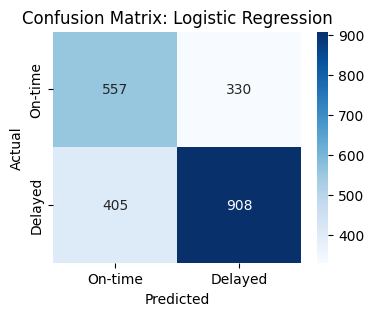

2025/06/16 21:42:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Evaluating Random Forest model:
Accuracy:  0.673
Precision: 0.868
Recall:    0.534
AUC:       0.742

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.88      0.68       887
           1       0.87      0.53      0.66      1313

    accuracy                           0.67      2200
   macro avg       0.71      0.71      0.67      2200
weighted avg       0.74      0.67      0.67      2200



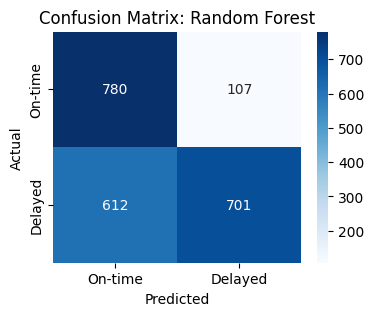

2025/06/16 21:42:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Evaluating XGBoost model:
Accuracy:  0.656
Precision: 0.698
Recall:    0.747
AUC:       0.752

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.52      0.55       887
           1       0.70      0.75      0.72      1313

    accuracy                           0.66      2200
   macro avg       0.64      0.63      0.64      2200
weighted avg       0.65      0.66      0.65      2200



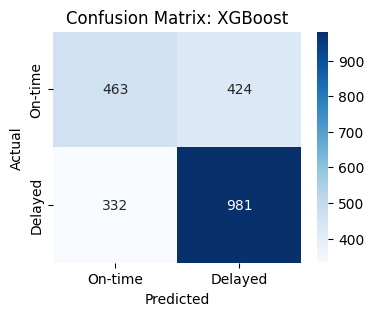

2025/06/16 21:42:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Evaluating LightGBM model:
Accuracy:  0.675
Precision: 0.860
Recall:    0.543
AUC:       0.744

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.87      0.68       887
           1       0.86      0.54      0.67      1313

    accuracy                           0.67      2200
   macro avg       0.71      0.71      0.67      2200
weighted avg       0.74      0.67      0.67      2200



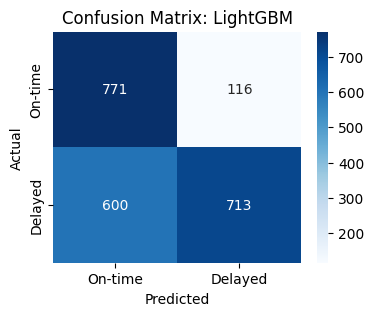

2025/06/16 21:42:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [25]:
# Evaluation and MLflow logging
for name, model in best_models.items():
    with mlflow.start_run(run_name=name):
        print(f"\nEvaluating {name} model:")

        y_pred = model.predict(X_test_encoded)
        y_proba = model.predict_proba(X_test_encoded)[:, 1]

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)

        print(f"Accuracy:  {accuracy:.3f}")
        print(f"Precision: {precision:.3f}")
        print(f"Recall:    {recall:.3f}")
        print(f"AUC:       {auc:.3f}")

        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Log metrics
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("auc", auc)

        # Plot confusion matrix (show only, no saving)
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(4,3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['On-time', 'Delayed'],
                    yticklabels=['On-time', 'Delayed'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix: {name}')
        plt.show()
        plt.close()

        # Save and log model
        model_path = os.path.join(models_path, f"{name.lower().replace(' ', '_')}_model.pkl")
        joblib.dump(model, model_path)
        mlflow.sklearn.log_model(model, artifact_path="model")

# Feature Importance


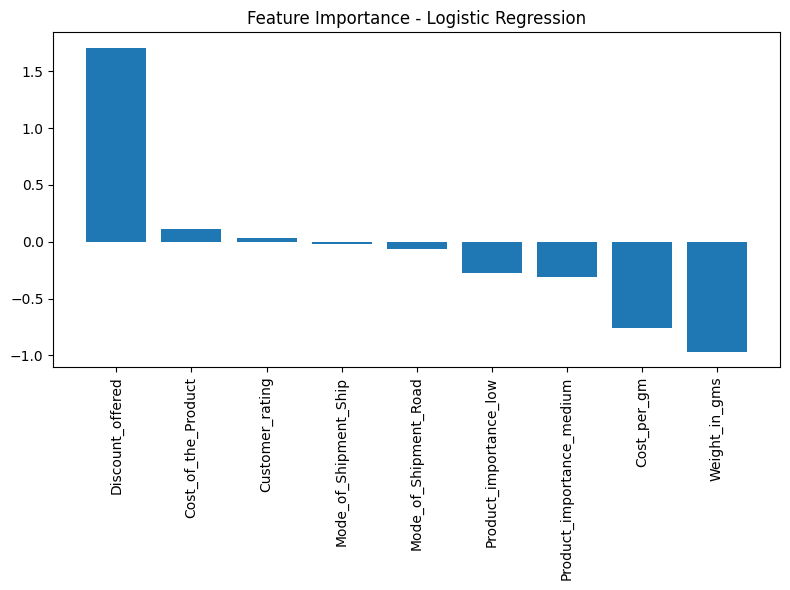

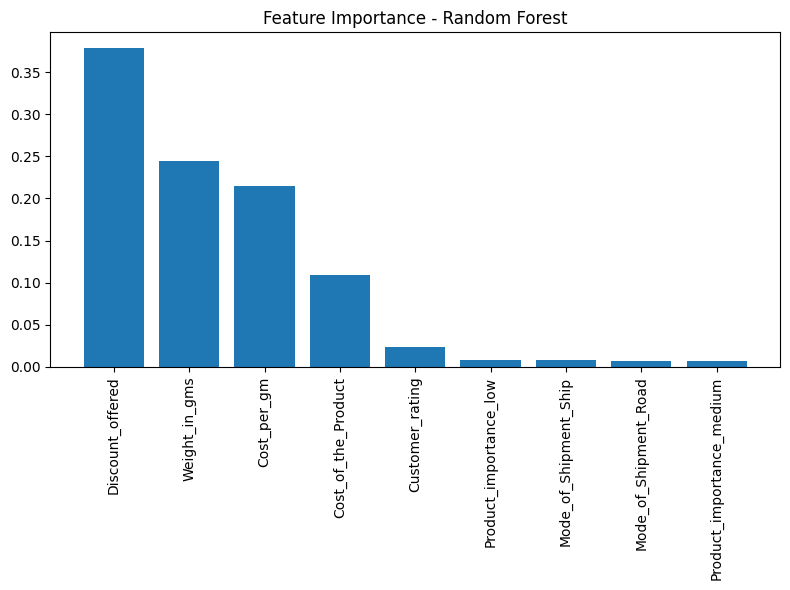

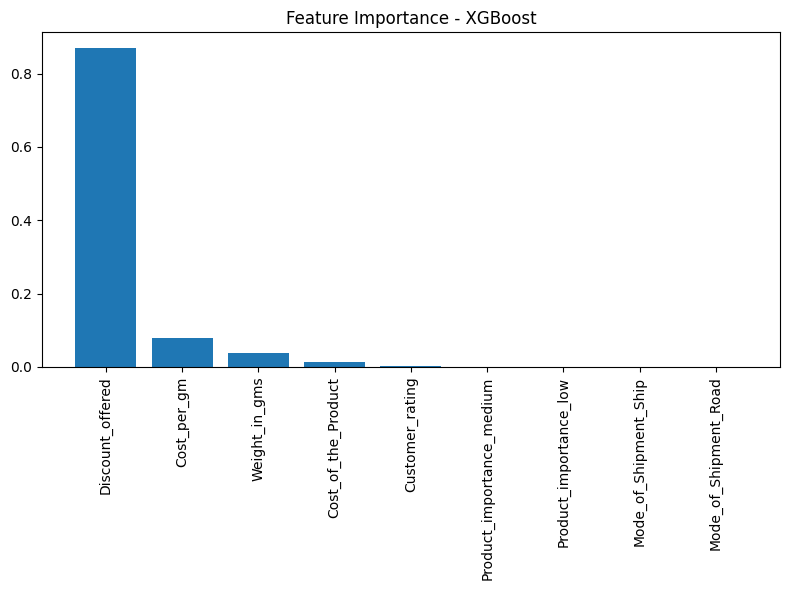

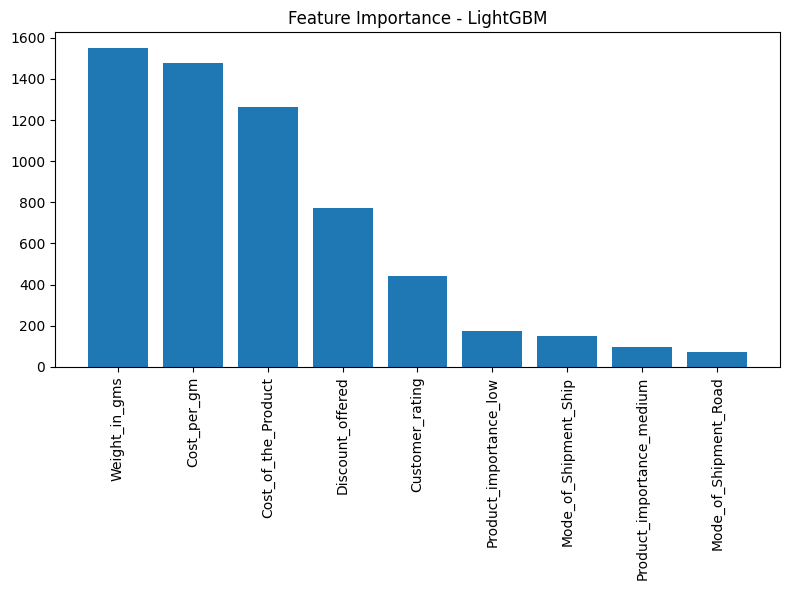

In [26]:
def plot_feature_importance(model, model_name, feature_names):
    plt.figure(figsize=(8,6))

    if model_name == 'Logistic Regression':
        # Coefficients for Logistic Regression
        importance = model.coef_[0]
    elif model_name == 'Random Forest':
        importance = model.feature_importances_
    elif model_name == 'XGBoost':
        importance = model.feature_importances_
    elif model_name == 'LightGBM':
        importance = model.feature_importances_
    else:
        print(f"Feature importance not supported for {model_name}")
        return
    
    # Sort feature importances
    indices = np.argsort(importance)[::-1]

    # Plot top 20 features or all if less
    top_n = min(20, len(feature_names))
    plt.bar(range(top_n), importance[indices][:top_n], align='center')
    plt.xticks(range(top_n), [feature_names[i] for i in indices][:top_n], rotation=90)
    plt.title(f"Feature Importance - {model_name}")
    plt.tight_layout()
    plt.show()

# Example usage
for name, model in best_models.items():
    plot_feature_importance(model, name, X_train_encoded.columns)


# Conclusion & Next Steps

| Model                   | Accuracy | Precision | Recall | AUC   | Comments                                              |
| ----------------------- | -------- | --------- | ------ | ----- | ----------------------------------------------------- |
| **Logistic Regression** | 0.666    | 0.733     | 0.692  | 0.737 | Balanced metrics; interpretable and consistent        |
| **Random Forest**       | 0.673    | 0.868     | 0.534  | 0.742 | Very high precision; weaker recall                    |
| **XGBoost**             | 0.656    | 0.698     | 0.747  | 0.752 | Best recall and AUC; strong for capturing positives   |
| **LightGBM**            | 0.675    | 0.860     | 0.543  | 0.744 | Highest precision; misses many positives (low recall) |


**Insights & Interpretation**

- XGBoost achieved the highest recall (0.747) and highest AUC (0.752), making it the best model for minimizing false negatives — important when missing positive cases has a high cost.

- LightGBM had the highest precision (0.860) but a low recall (0.543), indicating it misses many positive cases but is highly confident when predicting positives.

- Random Forest offered a strong balance of performance with very high precision (0.868) but lower recall (0.534), showing it is precise but less sensitive to positives.

- Logistic Regression showed stable and interpretable performance, with precision 0.733 and recall 0.692, though overall metrics were slightly lower compared to others.

**Conclusion**

- XGBoost is the best candidate if recall and AUC are key priorities (e.g., detecting as many true positives as possible).

- LightGBM is preferable when false positives are costly and high precision is required but should be used cautiously due to low recall.

- Random Forest and Logistic Regression can serve as benchmarks or backups due to their overall balanced but differing trade-offs between precision and recall.